### Imports

In [265]:
from functools import wraps
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand
import time

plt.style.use("default")
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

### Runtime

In [266]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Noise

In [267]:
# To run without noise, update the value to False
noise = False

filename = '.eps'
if noise: filename = '_noise.eps'

### Defining Parameters

In [268]:
mass = 1        # Mass of the Harmonic oscillator
K = 1

# Set the simulation parameters
dt_leap = 0.01    # stepsize
dt_euler = 0.01
t_max = 10.0   # maximum size

#### Hamiltonian dynamics for Harmonic oscillator

In [269]:
def hamiltonian_dynamics(t, x): # for harmonic oscillator (991) and (992) in optimization
    return np.array([x[1]/mass, -K*x[0]])

def gradient_potenital_energy(q): 
    return K*q

### Leapfrog integrator

In [270]:
# Define the Leapfrog integrator
def leapfrog(q, p, dt):
    p_half = p - 0.5*dt*gradient_potenital_energy(q)
    q_next = q + dt*p_half
    p_next = p_half - 0.5*dt*gradient_potenital_energy(q_next)
    return np.array([q_next, p_next])

def generate_trajectory(q0, p0, t_max, dt_leap):
    # Initialize the trajectory arrays
    t_leapfrog = np.arange(0, t_max, dt_leap)
    x_leapfrog = np.zeros((2, len(t_leapfrog)))

    # Set the initial values
    x_leapfrog[:, 0] = np.array([q0, p0])

    # Run the simulation using the Leapfrog integrator
    for i in range(1, len(t_leapfrog)):
        x_leapfrog[:, i] = leapfrog(x_leapfrog[0, i-1], x_leapfrog[1, i-1], dt_leap)

    return x_leapfrog

#### Plot example trajectory

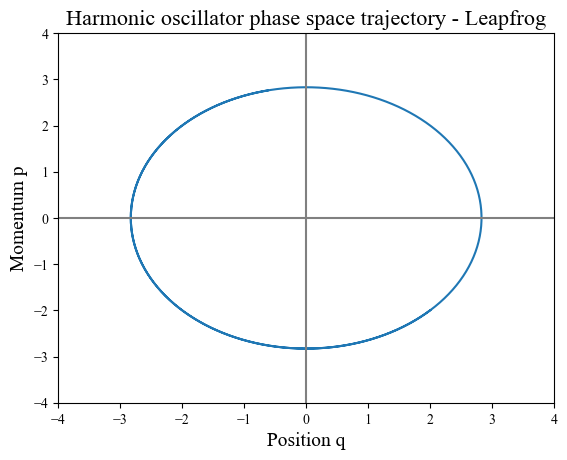

In [271]:
init_conditions = [[2, -2]]
x_leapfrog = []
legend = []

for i in range(len(init_conditions)):
    x = generate_trajectory(init_conditions[i][0], init_conditions[i][1], t_max, dt_leap)
    x_leapfrog.append(x)

# Plot the trajectory in phase space
for i in range(len(x_leapfrog)):
    plt.plot(x_leapfrog[i][0, :], x_leapfrog[i][1, :])
    legend.append(str(i+1))

plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
#plt.legend(legend, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Harmonic oscillator phase space trajectory - Leapfrog', fontsize=16)
#plt.savefig(r"hamilton_figures\harmonic_oscillator_leapfrog.eps", format ="eps")
plt.show()

### Explicit Euler method

In [272]:
# Based on eurlers method in MCMC using hamiltonian dynamics
def explicit_euler(q, p, dt):
    p_next = p - dt * gradient_potenital_energy(q) # update position
    q_next = q + dt * p/mass # update momentum
    return np.array([q_next, p_next])

def generate_trajectory_euler(q0, p0, t_max, dt_euler):
    # Initialize the trajectory arrays
    t_euler = np.arange(0, t_max, dt_euler)
    x_euler = np.zeros((2, len(t_euler)))

    # Set the initial values
    x_euler[:, 0] = np.array([q0, p0])

    # Run the simulation using the Euler integrator
    for i in range(1, len(t_euler)):
        x_euler[:, i]= explicit_euler(x_euler[0, i-1], x_euler[1, i-1], dt_euler)

    return x_euler

#### Plot example trajecory

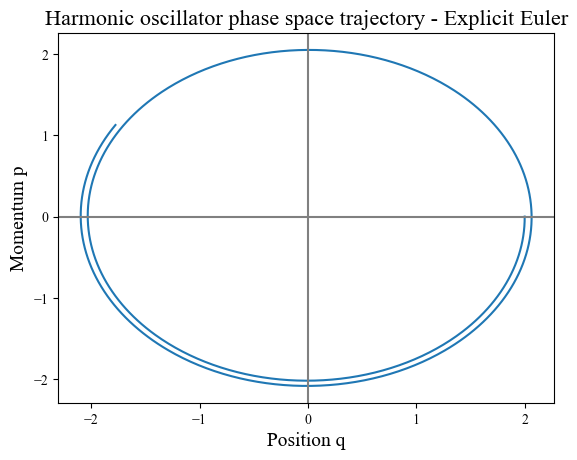

In [273]:
init_conditions_euler = [[2, 0]]
x_euler = []
legend_euler = []

for i in range(len(init_conditions_euler)):
    x = generate_trajectory_euler(init_conditions_euler[i][0], init_conditions_euler[i][1], t_max, dt_euler)
    x_euler.append(x)

# Plot the trajectory in phase space
for i in range(len(x_euler)):
    plt.plot(x_euler[i][0, :], x_euler[i][1, :])
    legend_euler.append(str(i+1))

# Plot the trajectory in phase space
plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
#plt.legend(legend_euler, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Harmonic oscillator phase space trajectory - Explicit Euler', fontsize=16)
#plt.savefig(r"hamilton_figures\harmonic_oscillator_euler.eps", format ="eps")
plt.show()

## Random Fourier Features

In [274]:
dim_of_function = 2
time_series = np.arange(0, t_max, dt_leap)
num_of_points = len(time_series)

start_state = np.array([2, 0])

sigma = 5
lambda_ = 0.0001
num_of_samples = 30

#w = randn(dim_of_function, num_of_samples)/sigma
#b = rand(1, num_of_samples)*2*np.pi
w = np.load('RFF_parameters/w_harmonic_oscillator_symplectic.npy')
b = np.load('RFF_parameters/b_harmonic_oscillator_symplectic.npy')

### Learning with RFF

#### Generate training trajectory

In [275]:
x_train = np.zeros((dim_of_function, num_of_points))
y_train = np.zeros_like(x_train)
noise_sigma = 0.01

x_train = generate_trajectory(start_state[0], start_state[1], t_max, dt_leap)

for i in range(len(x_train[0])):
    y_train[:, i] = hamiltonian_dynamics(0, x_train[:, i])

#noise_x = np.random.normal(loc=0.0, scale=noise_sigma, size=(dim_of_function, num_of_points))
#noise_y = np.random.normal(loc=0.0, scale=noise_sigma, size=(dim_of_function, num_of_points))
noise_x = np.load('RFF_parameters/noise_x_harmonic_oscillator_symplectic.npy')
noise_y = np.load('RFF_parameters/noise_y_harmonic_oscillator_symplectic.npy')

if noise: 
    x_train = x_train + noise_x
    y_train = y_train + noise_y

In [276]:
#np.save('RFF_parameters/noise_x_harmonic_oscillator_symplectic', noise_x)
#np.save('RFF_parameters/noise_y_harmonic_oscillator_symplectic', noise_y)

#### Plot training trajectory

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\2789243115.py:30: RuntimeWarning: invalid value encountered in scalar divide
  u_norm[i, j] = u[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\2789243115.py:31: RuntimeWarning: invalid value encountered in scalar divide
  v_norm[i, j] = v[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\2789243115.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator.show()


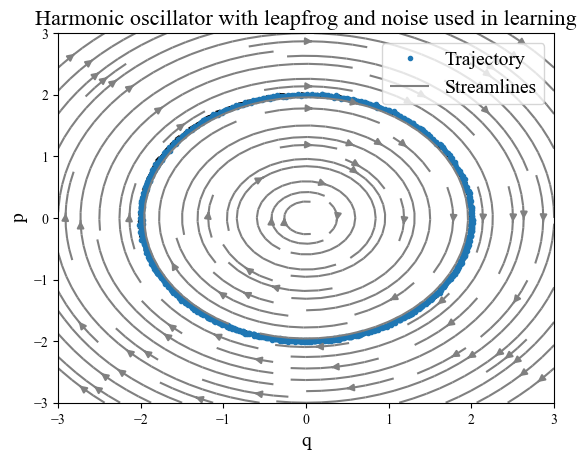

In [277]:
lower_bound_x1 = -3
upper_bound_x1 = 3
lower_bound_x2 = -3
upper_bound_x2 = 3

grid_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, grid_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, grid_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u = np.zeros(X1.shape)
v = np.zeros(X1.shape)
u_norm = np.zeros(X1.shape)
v_norm = np.zeros(X1.shape)

for (i, j), value in np.ndenumerate(X1):
    # get velocities at each point
    Y_prime = hamiltonian_dynamics(t, np.array([value, X2[i, j]]))
    u[i, j] = Y_prime[0]
    v[i, j] = Y_prime[1]

    # normalize vector length
    V_mod = np.sqrt(u[i, j]**2 + v[i, j]**2)
    u_norm[i, j] = u[i, j] / V_mod
    v_norm[i, j] = v[i, j] / V_mod

# Plot resulting trajectory in the data set and belonging streamlines
fig_harmonic_oscillator = plt.figure(4)
plt.title('Harmonic oscillator with leapfrog used in learning', fontsize=16)
if noise: plt.title('Harmonic oscillator with leapfrog and noise used in learning', fontsize=16)
plt.plot(x_train[0, :], x_train[1, :], '.', linewidth=1)
plt.streamplot(X1, X2, u, v, density=1.1, color='gray')
plt.quiver(x_train[0, :], x_train[1, :], y_train[0, :], y_train[1, :])
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Trajectory', 'Streamlines'], loc = 'upper right', frameon = True , prop ={'size': 14 } )
fig_harmonic_oscillator.show()

#plt.savefig("hamilton_figures/harmonic_oscillator_trajectory_leapfrog"+filename, format ="eps")

### RFF for Symplecitc kernel

In [278]:
def psi_symplectic(x, w, b):
    return np.sqrt(2)*np.cos(w.T@x + b)*w.T

def capital_psi_symplectic(x, w, b, d, dim):
    psi_vector_symplectic = np.zeros((d, dim))
    m = 1
    J = np.block([[np.zeros((m,m)), np.identity(m)],
              [-np.identity(m), np.zeros((m,m))]])
    for i in range(d):
        psi_element = psi_symplectic(x, w[:, i], b[:, i])
        psi_vector_symplectic[i] = J@psi_element
    return psi_vector_symplectic.T

def phi_symplectic(x, w, b, n, d, dim):
    phi = np.zeros((dim*n, d))
    for i in range(n):
        psi = capital_psi_symplectic(x[:, i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

@runtime
def alpha_approx_symplectic(x, y, dim, d, lam, n):
    phi_ = phi_symplectic(x, w, b, n, d, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(d))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

#### Estimate alpha

In [279]:
alpha_symplectic = alpha_approx_symplectic(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)


 Function alpha_approx_symplectic took 1.1415 seconds


#### Hamilton symplectic model

In [280]:
def learnt_model_symplectic(t, x):
    func = capital_psi_symplectic(x, w, b, num_of_samples, dim_of_function) @ alpha_symplectic
    return func

init_time = 0
timespan = np.array([init_time, t_max])
points = int(t_max/dt_leap)
t = np.linspace(init_time, t_max, points)

# Solve diff. equations using learnt model with solve_ivp
data_series_symplectic = solve_ivp(learnt_model_symplectic, timespan, start_state, t_eval=t).y

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\3327506359.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_hamilton.show()


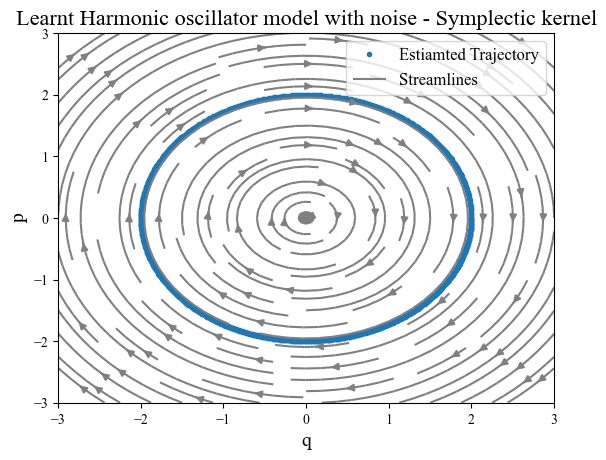

In [281]:
u_learnt_symplectic = np.zeros(X1.shape)
v_learnt_symplectic = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i, j), value in np.ndenumerate(X1):
    Y_prime = learnt_model_symplectic(t, np.array([value, X2[i, j]]))
    u_learnt_symplectic[i, j] = Y_prime[0]
    v_learnt_symplectic[i, j] = Y_prime[1]

# Plot simulated trajectory and streamslices for learnt model
fig_harmonic_oscillator_hamilton = plt.figure(6)
plt.title('Learnt Harmonic oscillator model - Symplectic kernel', fontsize=16)
if noise: plt.title('Learnt Harmonic oscillator model with noise - Symplectic kernel', fontsize=16)
plt.plot(data_series_symplectic[0, :], data_series_symplectic[1, :], '.', linewidth = 1)
plt.streamplot(X1, X2, u_learnt_symplectic, v_learnt_symplectic, density = 1.1, color ='gray')
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Estiamted Trajectory', 'Streamlines'], loc = 'upper right', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_hamilton.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_symplectic_model_lf"+filename, format ="eps")

#### Comparison of estimated and actual trajectory

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\1761119605.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_hamilton.show()


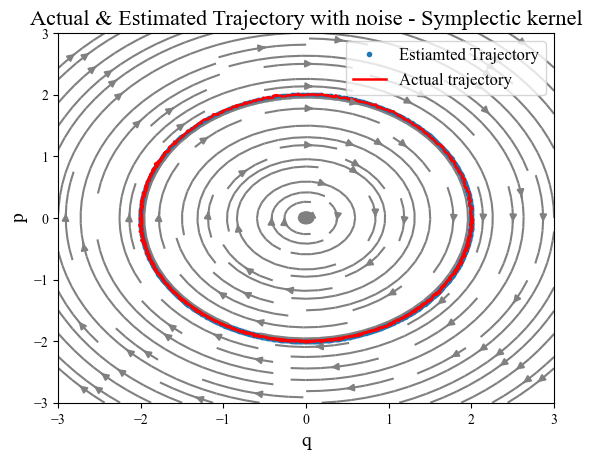

In [282]:
fig_harmonic_oscillator_hamilton = plt.figure(6)
plt.title('Actual Trajectory & Estimated Trajectory - Symplectic kernel', fontsize=16)
if noise: plt.title('Actual & Estimated Trajectory with noise - Symplectic kernel', fontsize=16)
plt.plot(data_series_symplectic[0, :], data_series_symplectic[1, :], '.', linewidth = 0.2)
plt.plot(x_train[0, :], x_train[1, :], '-', linewidth = 1.8, color='r')
plt.streamplot(X1, X2, u_learnt_symplectic, v_learnt_symplectic, density = 1.1, color ='gray')
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Estiamted Trajectory', 'Actual trajectory'], loc = 'upper right', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_hamilton.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_learnt_model_leapfrog"+filename, format ="eps")

#### Save satisfactory RFF parameters

In [283]:
#np.save('RFF_parameters/w_harmonic_oscillator_symplectic', w)
#np.save('RFF_parameters/b_harmonic_oscillator_symplectic', b)

### RFF for Gaussian separable kernel

In [284]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:, i])
    return np.array(psi_vector)

def capital_psi(x, w, b, d, dim):
    psi = psi_vector(x, w, b, d)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, n, d, dim):
    phi = np.zeros((dim*n, dim*d))
    for i in range(0, n):
        psi = capital_psi(x[:, i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

@runtime
def alpha_approx(x, y, dim, d, lam, n):
    phi_ = phi(x, w, b, n, d, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*d))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

#### Estimate alpha

In [285]:
alpha_gauss = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)


 Function alpha_approx took 0.6803 seconds


#### Gaussian model

In [286]:
def learnt_model_gauss(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_gauss
    return func

data_series = solve_ivp(learnt_model_gauss, timespan, start_state, t_eval=t).y

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\803824330.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_hamilton.show()


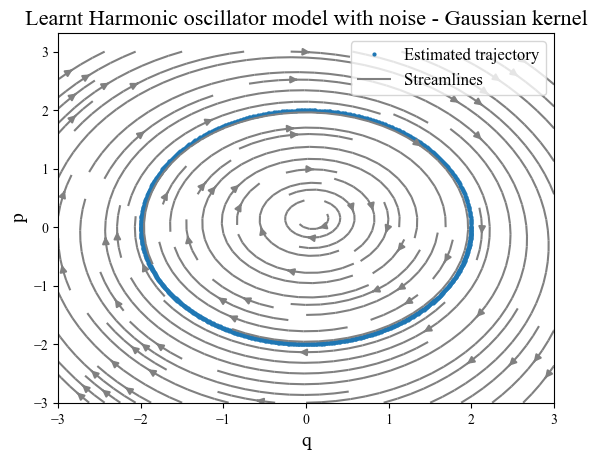

In [287]:
u_learnt_gaussian = np.zeros(X1.shape)
v_learnt_gaussian = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i, j), value in np.ndenumerate(X1):
    Y_prime = learnt_model_gauss(t, np.array([value, X2[i, j]]))
    u_learnt_gaussian[i, j] = Y_prime[0]
    v_learnt_gaussian[i, j] = Y_prime[1]

# Plot simulated trajectory and streamslices for learnt model
fig_harmonic_oscillator_hamilton = plt.figure(6)
plt.title('Learnt Harmonic oscillator model - Gaussian kernel', fontsize=16)
if noise: plt.title('Learnt Harmonic oscillator model with noise - Gaussian kernel', fontsize=16)
plt.plot(data_series[0, :], data_series[1, :], '.', markersize = 4)
plt.streamplot(X1, X2, u_learnt_gaussian, v_learnt_gaussian, density = 1.1, color ='gray')
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Estimated trajectory', 'Streamlines'], loc = 'upper right', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_hamilton.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_gauss_model_lf"+filename, format ="eps")

#### Comparison of estimated and actual trajectory

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\453447375.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_hamilton.show()


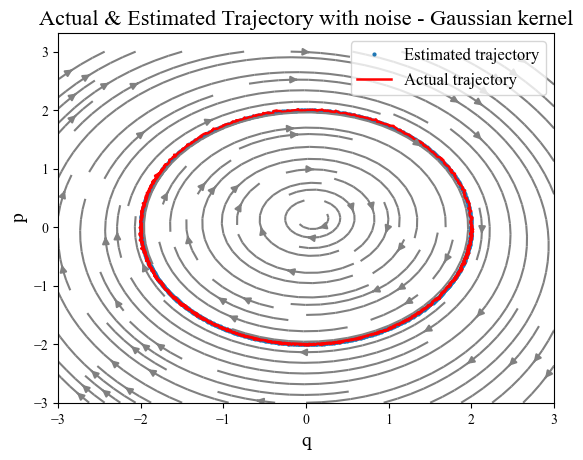

In [288]:
fig_harmonic_oscillator_hamilton = plt.figure(6)
plt.title('Actual Trajectory & Estimated Trajectory - Gaussian kernel', fontsize=16)
if noise: plt.title('Actual & Estimated Trajectory with noise - Gaussian kernel', fontsize=16)
plt.plot(data_series[0, :], data_series[1, :], '.', markersize = 4)
plt.plot(x_train[0, :], x_train[1, :], '-', linewidth = 1.8, color='r') 
plt.streamplot(X1, X2, u_learnt_gaussian, v_learnt_gaussian, density = 1.1, color ='gray')
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Estimated trajectory', 'Actual trajectory'], loc = 'upper right', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_hamilton.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_learnt_gauss_model"+filename, format ="eps")

### Reproduction accuracy

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\2412103675.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_error_symplectic.show()


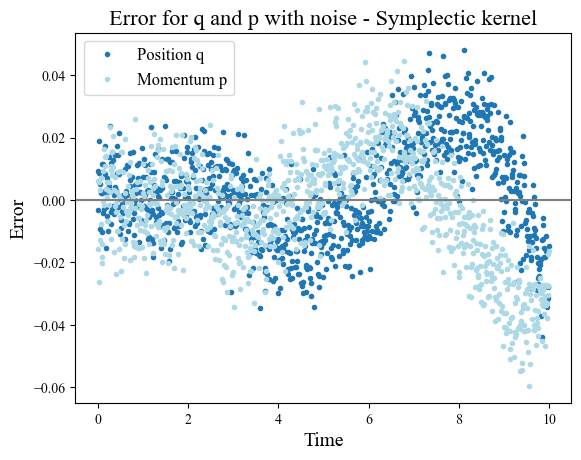

In [289]:
error_symplectic = x_train - data_series_symplectic

fig_harmonic_oscillator_error_symplectic = plt.figure(7)
plt.title('Error for q and p - Symplectic kernel', fontsize=16)
if noise: plt.title('Error for q and p with noise - Symplectic kernel', fontsize=16)
plt.plot(time_series, error_symplectic[0, :], '.', linewidth = 0.000001)
plt.plot(time_series, error_symplectic[1, :], '.', linewidth = 0.0000001, color = 'lightblue')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.axhline(y=0, color='grey')
plt.legend(['Position q', 'Momentum p'], loc = 'upper left', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_error_symplectic.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_error_symplectic"+filename, format ="eps")

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\2920940673.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_error_symplectic.show()


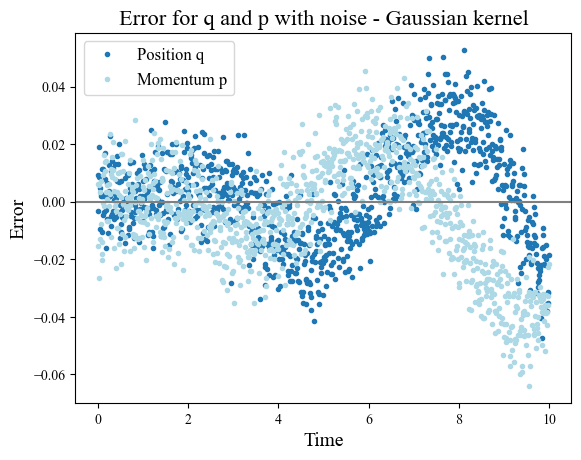

In [290]:
error_gauss = x_train - data_series

fig_harmonic_oscillator_error_symplectic = plt.figure(7)
plt.title('Error for q and p - Gaussian kernel', fontsize=16)
if noise: plt.title('Error for q and p with noise - Gaussian kernel', fontsize=16)
plt.plot(time_series, error_gauss[0, :], '.', linewidth = 0.000001)
plt.plot(time_series, error_gauss[1, :], '.', linewidth = 0.000001, color = 'lightblue')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.axhline(y=0, color='grey')
plt.legend(['Position q', 'Momentum p'], loc = 'upper left', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_error_symplectic.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_error_gauss"+filename, format ="eps")

C:\Users\vilde\AppData\Local\Temp\ipykernel_20372\3792260205.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_harmonic_oscillator_error_gauss_total.show()


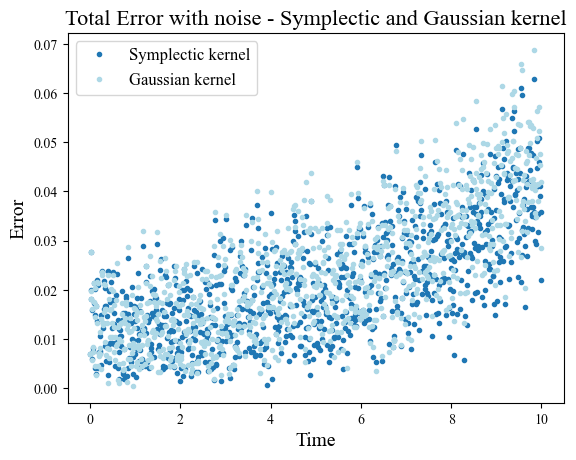

In [291]:
error_symplectic_total = np.linalg.norm(x_train - data_series_symplectic, ord=2, axis=0)
error_gauss_total = np.linalg.norm(x_train - data_series, ord=2, axis=0)

fig_harmonic_oscillator_error_gauss_total = plt.figure(8)
plt.title('Total Error - Symplectic and Gaussian kernel', fontsize=16)
if noise: plt.title('Total Error with noise - Symplectic and Gaussian kernel', fontsize=16)
plt.plot(time_series, error_symplectic_total, '.', linewidth = 0.000001)
plt.plot(time_series, error_gauss_total, '.', linewidth = 0.000001, color = 'lightblue')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.legend(['Symplectic kernel', 'Gaussian kernel'], loc = 'upper left', frameon = True , prop ={'size': 12 } )
fig_harmonic_oscillator_error_gauss_total.show()
#plt.savefig(r"hamilton_figures\harmonic_oscillator_hamilton_total_error_compare"+filename, format ="eps")

In [292]:
error_symplectic_mean = np.mean(np.linalg.norm(x_train - data_series_symplectic, ord=2, axis=0) / t_max)
error_gauss_mean = np.mean(np.linalg.norm(x_train - data_series, ord=2, axis=0) / t_max)

print(error_symplectic_mean)
print(error_gauss_mean)

0.002112880415901337
0.002343655298952759
